In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow as tf
import seaborn as sns
print(f'Seaborn: ', sns.__version__)
print(f'TensorFlow: ', tf.__version__)


Seaborn:  0.12.2
TensorFlow:  2.7.0


In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("data/kddcup.data.corrected", sep=",", names=columns, index_col=None)


In [3]:
# Filter to only 'http' attacks
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)


In [4]:
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))

encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 


In [6]:
# Check the variables with highest correlation with 'label'
df2 = df.copy()
label_corr = df2.corr()['label']

In [7]:
# Filter out anything that has null entry or is not weakly correlated
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
train_cols

['src_bytes',
 'hot',
 'num_compromised',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [8]:
# Removing these two columns as their correlation with 'src_bytes' is high
remove_cols = ['hot', 'num_compromised']
for r in remove_cols:
    train_cols.remove(r)

In [9]:
scaler_map = {}
for col in train_cols:
    scaler = MinMaxScaler()
    df2[col] = scaler.fit_transform(df2[col].values.reshape(-1, 1))
    scaler_map[col] = scaler 


In [10]:
normal_df = df2[df2['label'] == 0]
anomaly_df = df2[df2['label'] == 1]


In [11]:
labels_norm = normal_df['label']
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(normal_df[train_cols].values, labels_norm.values, test_size=0.15, random_state=42) 

In [12]:
# Additional split of training dataset to create validation split
x_test_anom, x_val_anom, y_test_anom, y_val_anom = train_test_split(anomaly_df[train_cols].values, anomaly_df['label'].values, test_size=0.2, random_state=42)

In [13]:
# Additional split of training dataset to create validation split
x_train, x_val_norm, y_train, y_val_norm = train_test_split(x_train_norm, y_train_norm, test_size=0.1, random_state=42)

In [14]:
x_test = np.concatenate((x_test_norm, x_test_anom))
y_test = np.concatenate((y_test_norm, y_test_anom))
x_val = np.concatenate((x_val_norm, x_val_anom))
y_val = np.concatenate((y_val_norm, y_val_anom))
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(473570, 11)
y_train:(473570,)

x_val:(53428, 11)
y_val:(53428,)

x_test:(96093, 11)
y_test:(96093,)


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)


In [28]:
# The input layer requires you to specify the dimensionality of the x-features (and not the number of samples)
noise_dimension = 50
data_dim = x_train.shape[-1]
## GENERATOR
g_in = Input(shape=(noise_dimension))
g_h1 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_in)
g_bn1 = BatchNormalization()(g_h1)
g_h2 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn1)
g_bn2 = BatchNormalization()(g_h2)
g_h3 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn2)
g_bn3 = BatchNormalization()(g_h3)
g_h4 = Dense(data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn3)
g_bn4 = BatchNormalization()(g_h4)
g_out = Dense(data_dim, activation='relu', )(g_bn4)


# Creating a model by specifying the input layer and output layer
generator = Model(g_in, g_out)

In [29]:
## DISCRIMINATOR
d_in = Input(shape=(data_dim))
d_h1 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_in)
d_bn1 = BatchNormalization()(d_h1)
d_h2 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn1)
d_bn2 = BatchNormalization()(d_h2)
d_h3 = Dense(2*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn2)
d_bn3 = BatchNormalization()(d_h3)
d_h4 = Dense(data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn3)

d_out = Dense(1, activation='linear',)(d_h4)

# Creating a model by specifying the input layer and output layer
discriminator = Model(d_in, d_out)

In [30]:
g_optim = RMSprop(5e-5)
d_optim = RMSprop(1e-5)

In [31]:
batch_size = 4096
train_dataset = tf.data.Dataset.from_tensor_slices(x_train[:]).shuffle(len(x_train[:])).batch(batch_size)


In [32]:
def gradient_penalty(critic, real_data, generated_data):
    alpha = tf.random.uniform([real_data.shape[0], 1], 0., 1.)
    interpolated_data = alpha * tf.cast(real_data, 'float32') + (1. - alpha) * generated_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated_data)
        critic_interpolated = critic(interpolated_data)
        
    gradients = tape.gradient(critic_interpolated, [interpolated_data])[0]
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
    gradient_penalty = tf.reduce_mean((gradients_norm - 1.)**2)
    
    return gradient_penalty

epochs = 10
lambda_gp = 10

g_loss = 0
d_loss = 0
d_loss_real = 0
d_loss_fake = 0
for e in range(epochs):
    print(f'\nEpoch {e}')
    for i, batch_x in enumerate(train_dataset):
        print(f'\r  {i}/{len(train_dataset)}: g_loss {g_loss} | d_loss: {d_loss} real {d_loss_real} fake {d_loss_fake}'.ljust(100, ' '), end='')

        random_noise = tf.random.normal([len(batch_x), noise_dimension])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            g_output = generator(random_noise)

            real_outputs = discriminator(batch_x)
            fake_outputs = discriminator(g_output)

            g_loss = -1*tf.keras.backend.mean(tf.ones_like(fake_outputs) * fake_outputs)

            d_loss_real = tf.keras.backend.mean(tf.ones_like(real_outputs) * real_outputs)
            d_loss_fake = tf.keras.backend.mean(tf.ones_like(fake_outputs) * fake_outputs)

            # # d_loss = d_loss_real - d_loss_fake 
            gp = gradient_penalty(discriminator, batch_x, g_output)
            
            # Combine losses
            d_loss = d_loss_real - d_loss_fake + lambda_gp * gp
            
        d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))

        g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
        g_optim.apply_gradients(zip(g_grads, generator.trainable_variables))
    preds = discriminator.predict(x_val)
    preds = np.where(preds.reshape(-1) < 0, 0, 1)
    print('\n', precision_score(y_val, preds), recall_score(y_val, preds), f1_score(y_val, preds))


Epoch 0
  115/116: g_loss -0.23272466659545898 | d_loss: 4.443209171295166 real -0.3765527606010437 fake 0.23272466659545898226
 0.9933422103861518 0.9221260815822002 0.9564102564102565

Epoch 1
  115/116: g_loss -0.8314056396484375 | d_loss: 1.3387994766235352 real -0.4450206160545349 fake 0.831405639648437536
 0.9973404255319149 0.927070457354759 0.9609224855861628

Epoch 2
  115/116: g_loss -1.8064360618591309 | d_loss: -0.49550795555114746 real -0.508586049079895 fake 1.806436061859130936
 0.9986684420772304 0.927070457354759 0.9615384615384616

Epoch 3
  115/116: g_loss -3.4109129905700684 | d_loss: -1.8184123039245605 real -0.5498615503311157 fake 3.4109129905700684
 0.9973579920739762 0.9332509270704573 0.9642401021711366

Epoch 4
  115/116: g_loss -5.768181800842285 | d_loss: -4.170583724975586 real -0.5694270133972168 fake 5.76818180084228545
 0.9960681520314548 0.9394313967861557 0.9669211195928753

Epoch 5
  115/116: g_loss -9.104137420654297 | d_loss: -7.686542510986328 re

In [39]:
# Seed search if needed. Keep the batch_size the same as when you'll be training
results = {}
best_score = 0
best_seed = None 
# Can set a high batch size to make seed search go faster. Set to what your GPU can handle
batch_size = 4096
train_dataset = tf.data.Dataset.from_tensor_slices(x_train[:50000]).shuffle(len(x_train[:50000])).batch(batch_size)
for seed in range(100):
    print(f'\r{seed}', end='')
    # seed = 10
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)

    noise_dimension = 50
    data_dim = x_train.shape[-1]
    ## GENERATOR
    g_in = Input(shape=(noise_dimension))
    g_h1 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_in)
    g_bn1 = BatchNormalization()(g_h1)
    g_h2 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn1)
    g_bn2 = BatchNormalization()(g_h2)
    g_h3 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn2)
    g_bn3 = BatchNormalization()(g_h3)
    g_h4 = Dense(data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal')(g_bn3)
    g_bn4 = BatchNormalization()(g_h4)
    g_out = Dense(data_dim, activation='relu', )(g_bn4)
    
    # Creating a model by specifying the input layer and output layer
    generator = Model(g_in, g_out)
    
    ## DISCRIMINATOR
    d_in = Input(shape=(data_dim))
    d_h1 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_in)
    d_bn1 = BatchNormalization()(d_h1)
    d_h2 = Dense(4*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn1)
    d_bn2 = BatchNormalization()(d_h2)
    d_h3 = Dense(2*data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn2)
    d_bn3 = BatchNormalization()(d_h3)
    d_h4 = Dense(data_dim, activation=LeakyReLU(alpha=0.01), kernel_initializer = 'he_normal', )(d_bn3)
    
    d_out = Dense(1, activation='linear',)(d_h4)
    
    # Creating a model by specifying the input layer and output layer
    discriminator = Model(d_in, d_out)
    
    g_optim = RMSprop(5e-5)
    d_optim = RMSprop(1e-5)
    
    batch_size = 4096
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train[:50000]).shuffle(len(x_train[:50000])).batch(batch_size)
    # Add checkpointing and load the best one in relation to the validation set
    
    def gradient_penalty(critic, real_data, generated_data):
        alpha = tf.random.uniform([real_data.shape[0], 1], 0., 1.)
        interpolated_data = alpha * tf.cast(real_data, 'float32') + (1. - alpha) * generated_data
        with tf.GradientTape() as tape:
            tape.watch(interpolated_data)
            critic_interpolated = critic(interpolated_data)
            
        gradients = tape.gradient(critic_interpolated, [interpolated_data])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.)**2)
        
        return gradient_penalty
        
    epochs = 1
    lambda_gp = 10
    
    g_loss = 0
    d_loss = 0
    d_loss_real = 0
    d_loss_fake = 0
    loss_fn = BinaryCrossentropy()
    for e in range(epochs):
        for i, batch_x in enumerate(train_dataset):
            # print(f'\r  {i}/{len(train_dataset)}: g_loss {g_loss} | d_loss: {d_loss} real {d_loss_real} fake {d_loss_fake}'.ljust(100, ' '), end='')
    
            random_noise = tf.random.normal([len(batch_x), noise_dimension])
    
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                g_output = generator(random_noise)
    
                real_outputs = discriminator(batch_x)
                fake_outputs = discriminator(g_output)
    
                g_loss = -1*tf.keras.backend.mean(tf.ones_like(fake_outputs) * fake_outputs)
    
                d_loss_real = tf.keras.backend.mean(tf.ones_like(real_outputs) * real_outputs)
                d_loss_fake = tf.keras.backend.mean(tf.ones_like(fake_outputs) * fake_outputs)
    
                # # d_loss = d_loss_real - d_loss_fake 
                gp = gradient_penalty(discriminator, batch_x, g_output)
                
                # Combine losses
                d_loss = d_loss_real - d_loss_fake + lambda_gp * gp
                
            d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
            d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    
          
            g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
            g_optim.apply_gradients(zip(g_grads, generator.trainable_variables))
        preds = discriminator.predict(x_val)
        preds = np.where(preds.reshape(-1) < 0, 0, 1)

        f1 = f1_score(y_val, preds)
        if f1 > best_score:
            best_score = f1
            best_seed = seed 
            print('\n', 'seed: ', seed, 
                  'precision: ', precision_score(y_val, preds), 
                  'recall: ', recall_score(y_val, preds), 
                  'f1: ', f1_score(y_val, preds))
        results[seed] = f1
        

1
 seed:  1 precision:  0.17236084452975048 recall:  0.5550061804697157 f1:  0.2630345635618044
10
 seed:  10 precision:  0.9920212765957447 recall:  0.9221260815822002 f1:  0.9557975656630365
99

In [40]:
print(f'Best seed: {best_seed} with F1: {results[best_seed]}')

Best seed: 10 with F1: 0.9557975656630365


In [33]:
preds = discriminator.predict(x_test)
y_pred = np.where(preds.reshape(-1) < 0, 0, 1)


In [34]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.995598868280415
Recall: 0.9786773794808405
F1-Measure: 0.9870656069814555


In [35]:
pd.Series(y_pred).value_counts()

0    92912
1     3181
Name: count, dtype: int64

In [36]:
pd.Series(y_test).value_counts()

0    92857
1     3236
Name: count, dtype: int64

Text(33.0, 0.5, 'True Label')

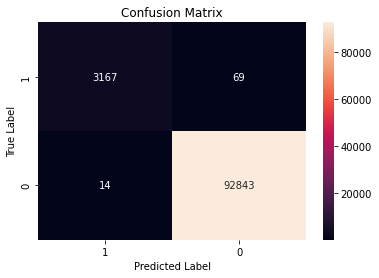

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt='0.0f')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')